# Tutorial 3: Visualisation of TabEBM's learned class-conditional distributions under data noise and class imbalance

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# Visualisation APIs are only compatible with previous versions of TabEBM
!pip install tabebm==2024.10.6

In [2]:
from tabebm.TabEBM import TabEBM
from tabebm.TabEBM import plot_TabEBM_energy_contour

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [3]:
# ==== Plot class-conditional energy varying the uncertainty ====
def plot_tabebm_probabilities(X, y, title_prefix='', title_suffix='', h=0.3):
    fig, axis = plt.subplots(1, 3, figsize=(20, 5), squeeze=False)
    fig.suptitle(f'{title_prefix} TabEBM approximated probabilities p(x|y=0) and p(x|y=1). {title_suffix}', fontsize=20)
    x_min = X[:, 0].min() - 0.5
    x_max = X[:, 0].max() + 0.5
    y_min = X[:, 1].min() - 0.5
    y_max = X[:, 1].max() + 0.5

    # ==== Plot the dataset ====
    if len(np.unique(y)) == 2:
        cmap_colors = ['red', 'grey']
    else:
        cmap_colors = sns.color_palette("viridis", len(np.unique(y)))

    for i, class_to_plot in enumerate(np.unique(y)):
        X_class = X[y == class_to_plot]
        axis[0, 0].scatter(X_class[:, 0], X_class[:, 1], c=cmap_colors[i], label=f'Class {class_to_plot}')
    axis[0, 0].set_title('Real data', fontsize=18)
    axis[0, 0].set_xlim(x_min, x_max)
    axis[0, 0].set_ylim(y_min, y_max)
    axis[0, 0].set_aspect('equal')
    axis[0, 0].set_xticks([])
    axis[0, 0].set_yticks([])

    # ==== TabEBM ====
    plot_TabEBM_energy_contour(
        tabebm, X, y, target_class=0,
        
        ax=axis[0, 1],
        show_unnormalized_prob=True,
        color_all_scatter_points_in=cmap_colors[0],
        h = h,
        x_min_user = x_min, x_max_user = x_max,
        y_min_user = y_min, y_max_user = y_max,
    )
    axis[0, 1].set_title('TabEBM (ours) inferred p(x|y=0)', fontsize=17)

    plot_TabEBM_energy_contour(
        tabebm, X, y, target_class=1,
        
        ax=axis[0, 2],
        show_unnormalized_prob=True,
        color_all_scatter_points_in=cmap_colors[1],
        h = h,
        x_min_user = x_min, x_max_user = x_max,
        y_min_user = y_min, y_max_user = y_max,
    )
    axis[0, 2].set_title('TabEBM (ours) inferred p(x|y=1)', fontsize=17)
    plt.tight_layout()

# Recreating the TabEBM plots investigated in Appendix "Limitations of Existing Generative Methods"

Note that the blobs are randomly generated, so they might be minor differences from those shown in the Appendix. However, the conclusion is unchanged: **TabEBM is robustly learns the class-conditionals of the data, even when under severe class noise and imbalance.**

In [4]:
tabebm = TabEBM(plotting=True)

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


# Scenario data noise: Circles dataset increasing the noise

In [5]:
h = 0.2  # The resolution of the contour plots

In [6]:
# ==== Code to generate the datasets ====
from sklearn.datasets import make_circles

def circles_dataset(n_samples, noise):
	X, y = make_circles(n_samples=n_samples, noise=noise, factor=0.4, random_state=1)
	return X, y

def create_two_blobs_at_distance(num_samples=200, blob1_num_samples=None, blob2_num_samples=None, distance=1.0, random_state=42):
	"""
	Create two datasets at a distance D from the center
	"""
	# sample points from a Gaussian distribution using the same random state
	if num_samples!=None:
		np.random.seed(random_state)
		X1 = np.random.randn(num_samples//2, 2) # class 1
		X2 = np.random.randn(num_samples//2, 2) # class 2
	else:
		X1 = np.random.randn(blob1_num_samples, 2) # class 1
		X2 = np.random.randn(blob2_num_samples, 2) # class 2

	# Shift the second class at a distance D from the center on the x-axis
	X1[:,0] -= distance/2
	X2[:,0] += distance/2

	# Concatenate the two datasets
	X = np.concatenate([X1, X2], axis=0)
	y = np.concatenate([np.zeros(len(X1)), np.ones(len(X2))], axis=0)

	return X, y

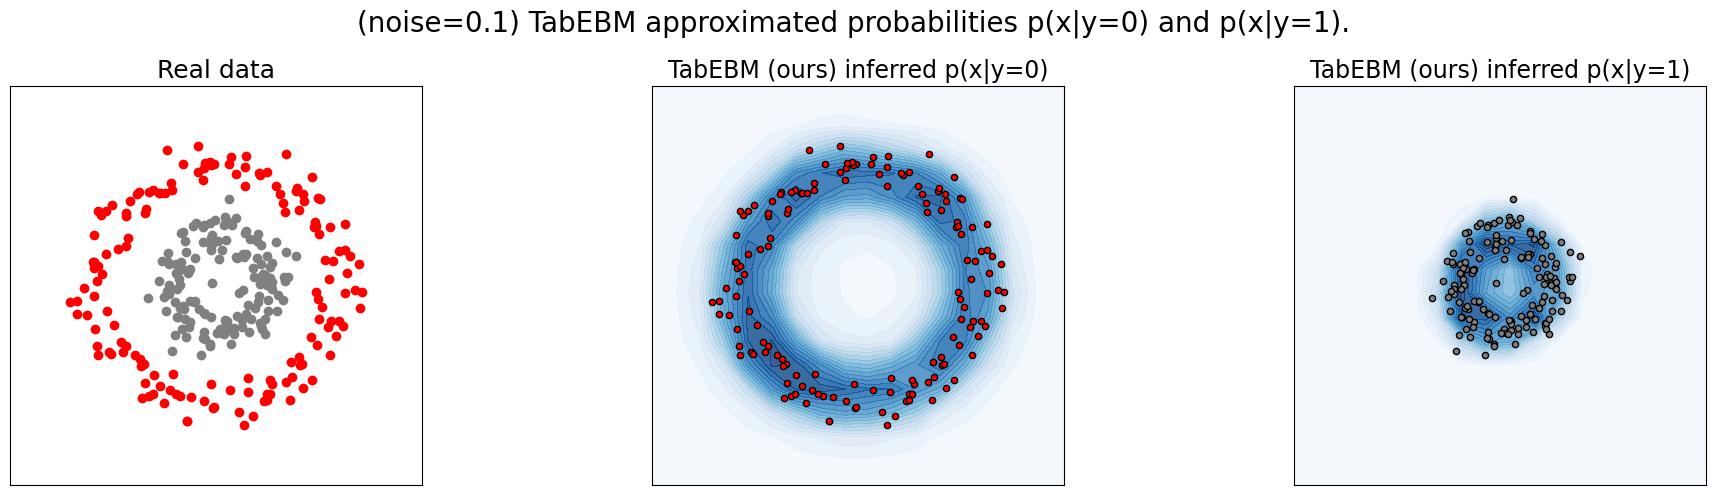

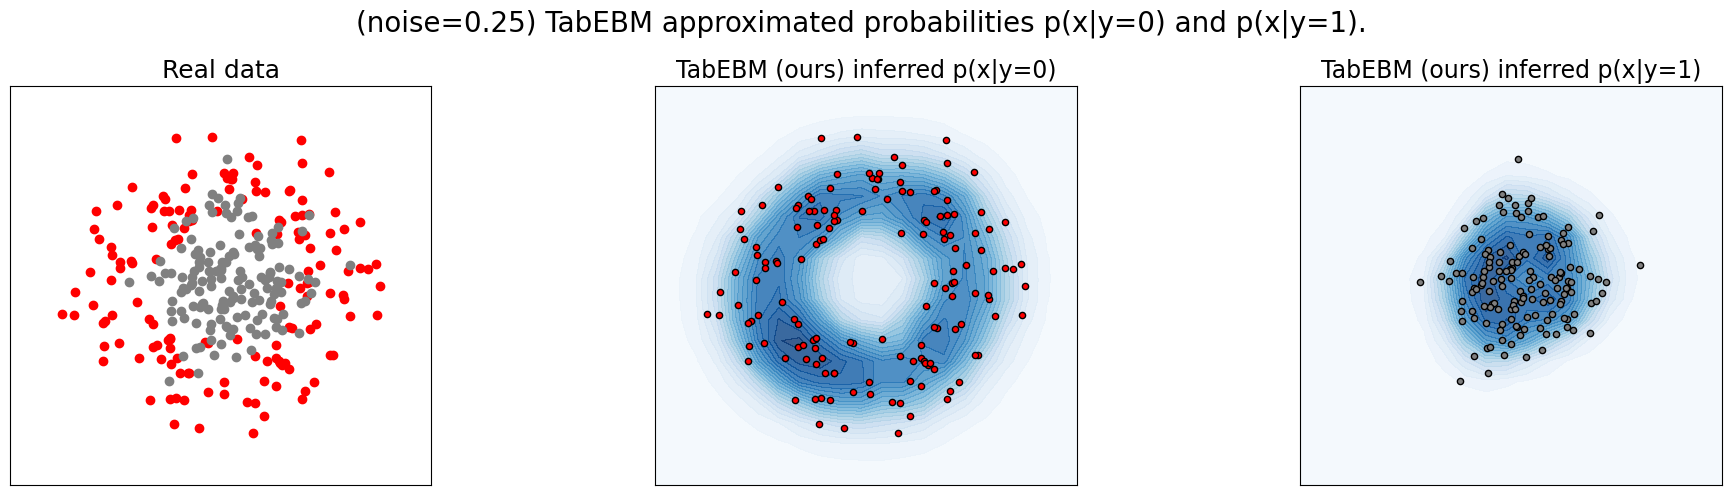

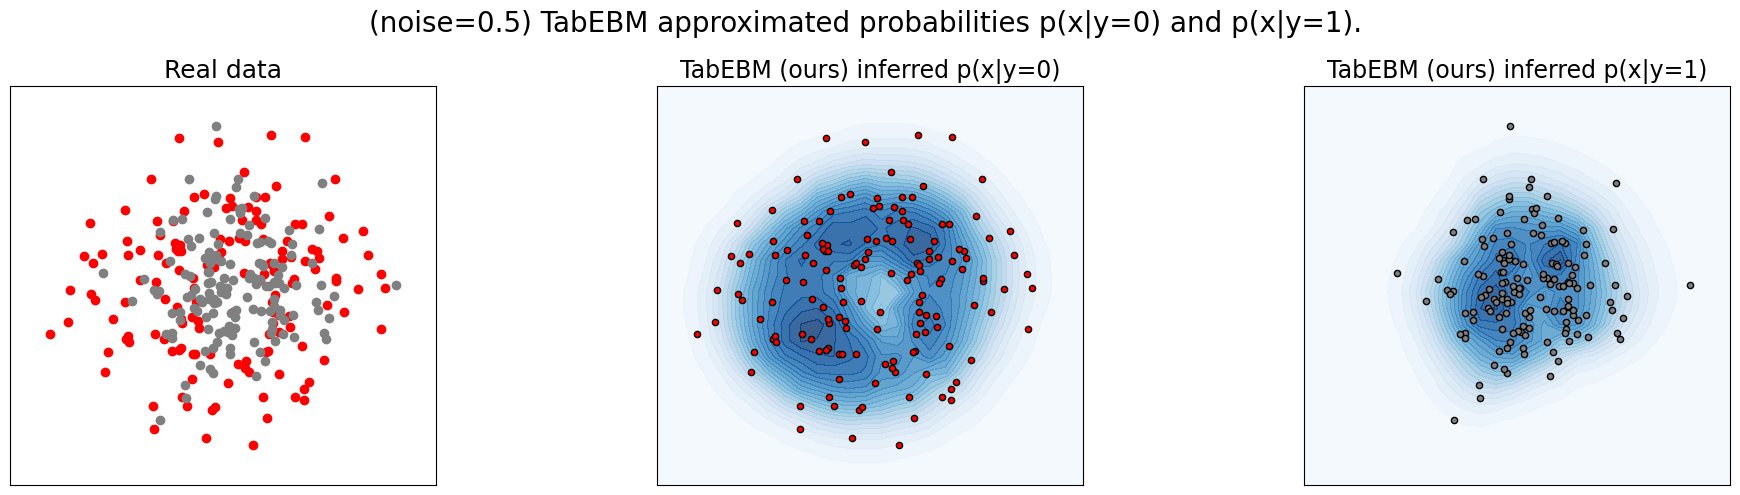

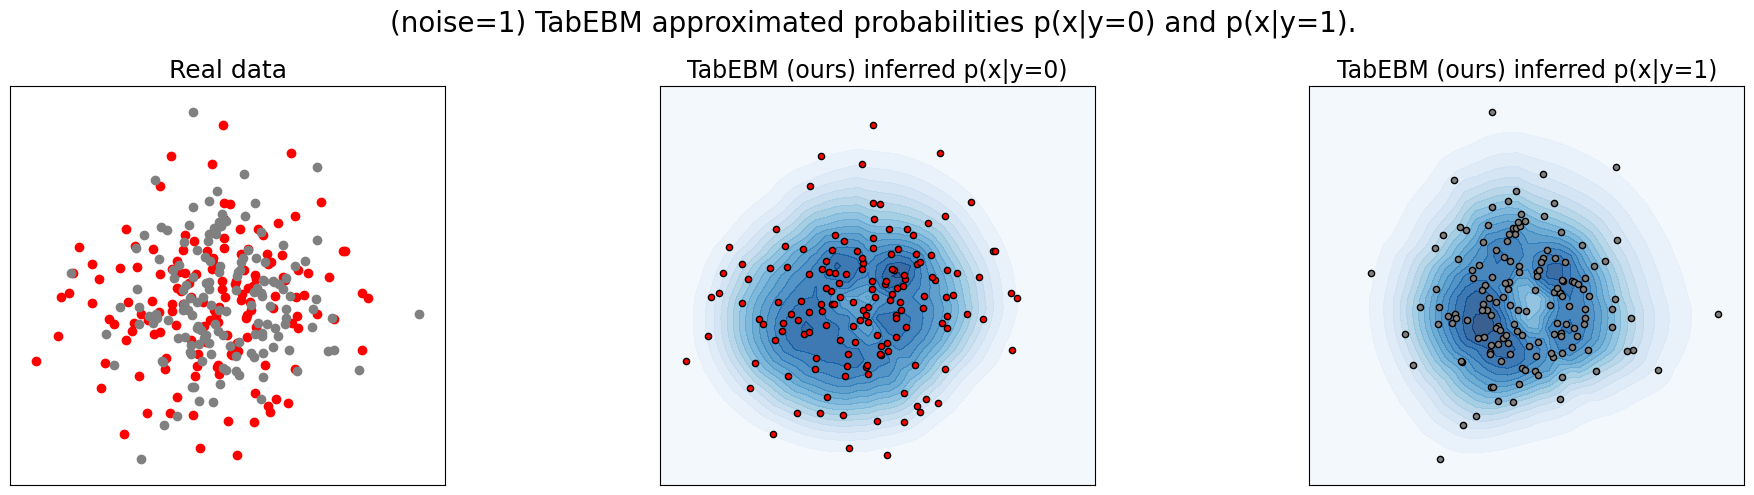

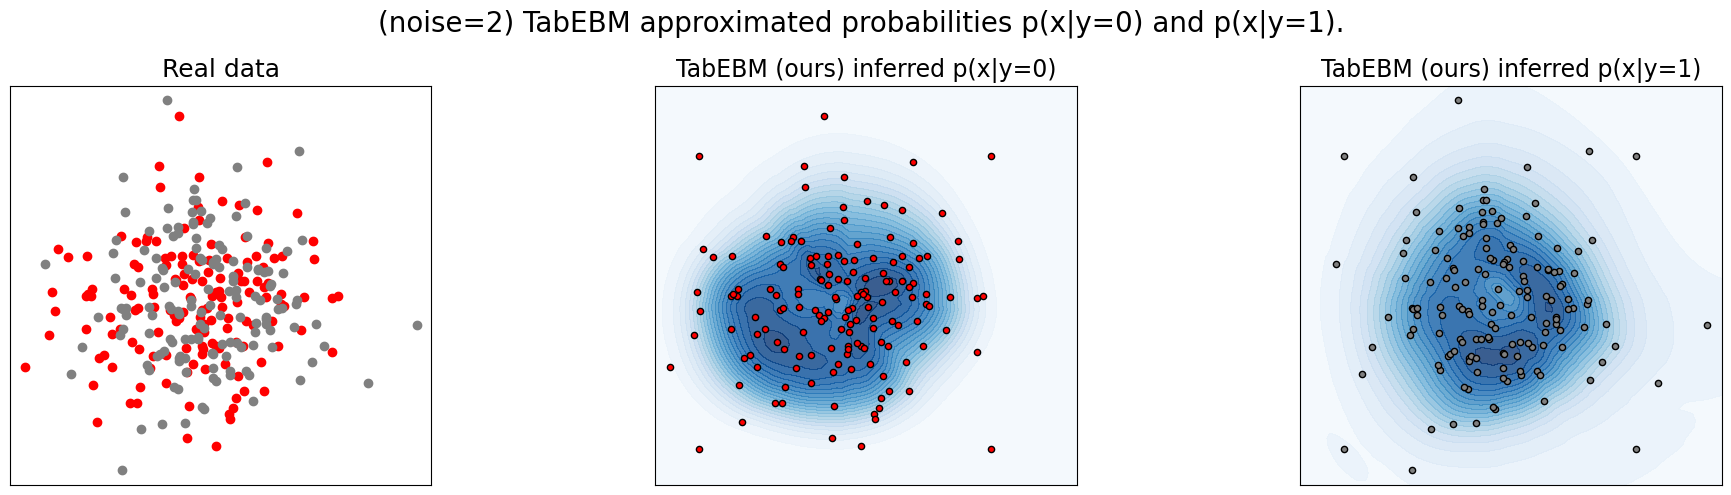

In [7]:
X, y = circles_dataset(n_samples=300, noise=0.1)
plot_tabebm_probabilities(X, y, title_prefix='(noise=0.1)', h=h)
plt.show()

X, y = circles_dataset(n_samples=300, noise=0.25)
plot_tabebm_probabilities(X, y, title_prefix='(noise=0.25)', h=h)
plt.show()

X, y = circles_dataset(n_samples=300, noise=0.5)
plot_tabebm_probabilities(X, y, title_prefix='(noise=0.5)', h=h)
plt.show()

X, y = circles_dataset(n_samples=300, noise=1)
plot_tabebm_probabilities(X, y, title_prefix='(noise=1)', h=h)
plt.show()

X, y = circles_dataset(n_samples=300, noise=2)
plot_tabebm_probabilities(X, y, title_prefix='(noise=2)', h=h)
plt.show()

## === Finding: TabEBM is robust to noise in the data ===

# Scenario class imbalance: Two Gaussian blobs of different sizes

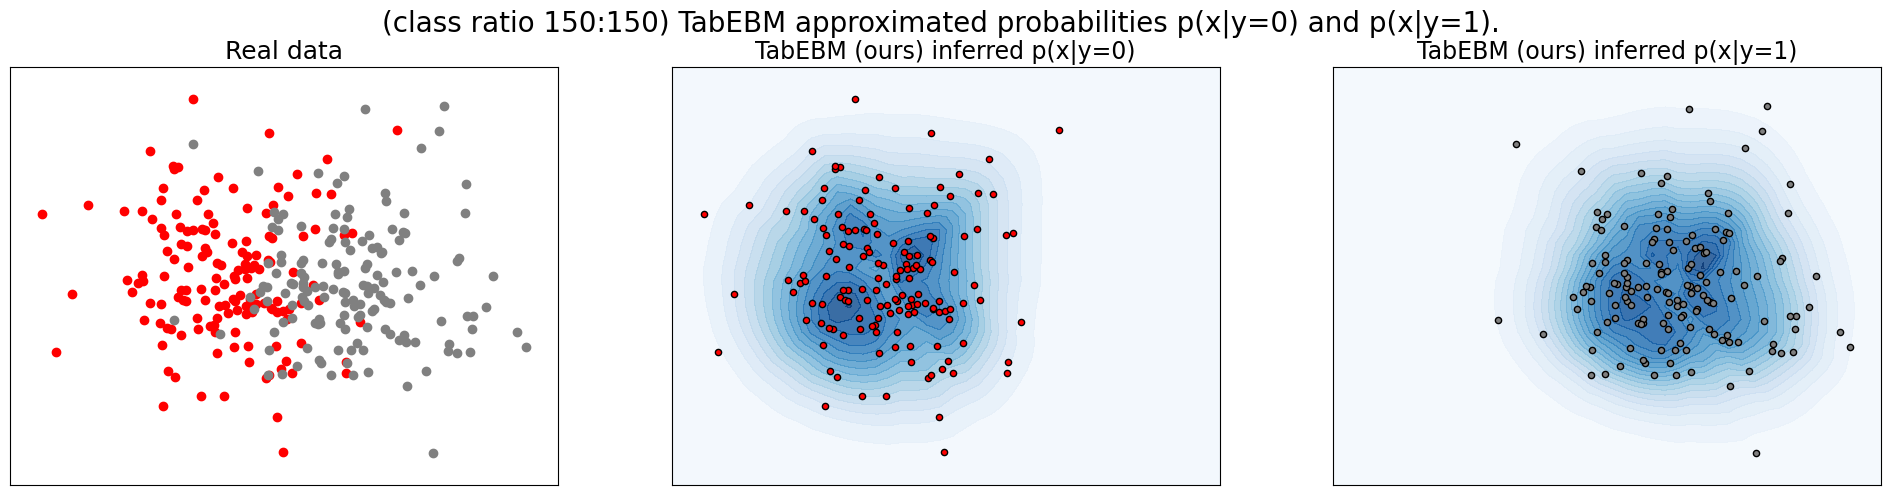

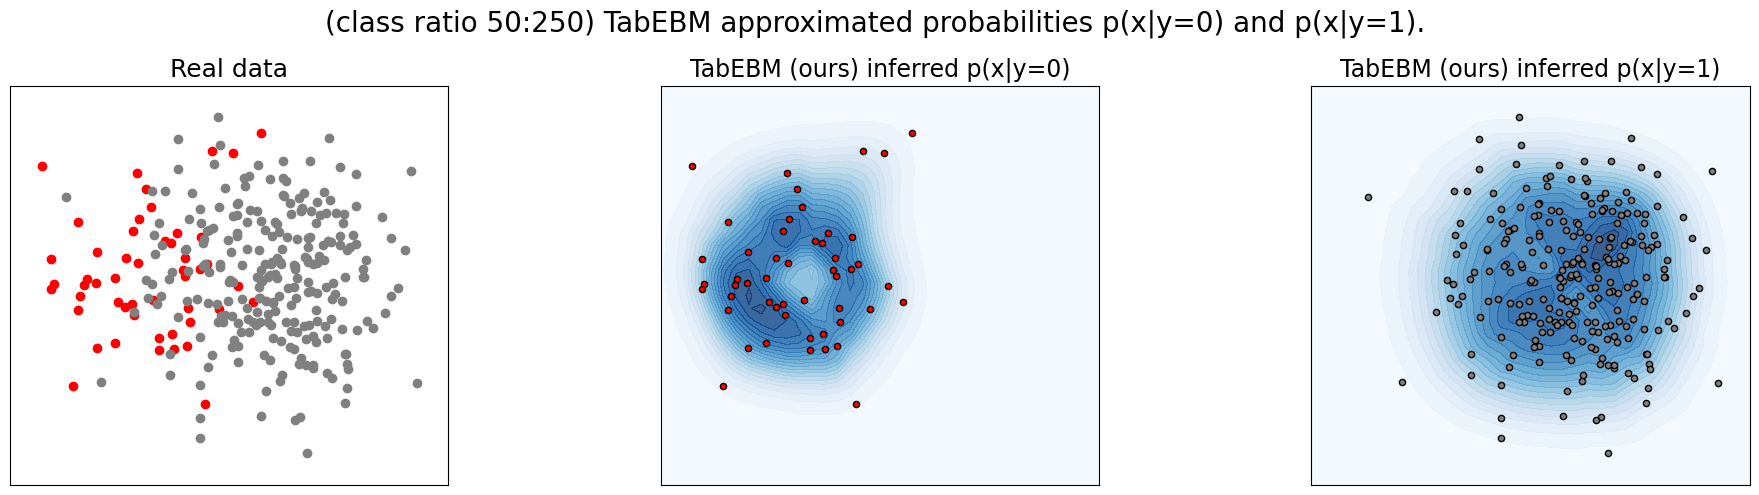

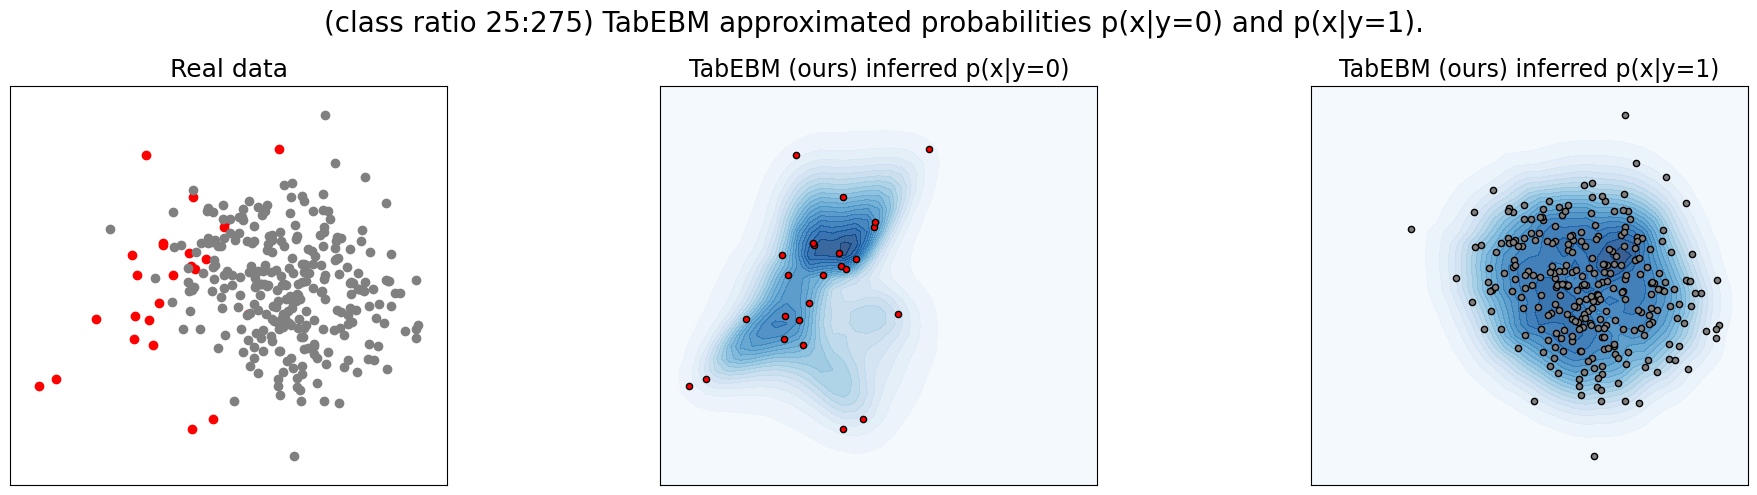

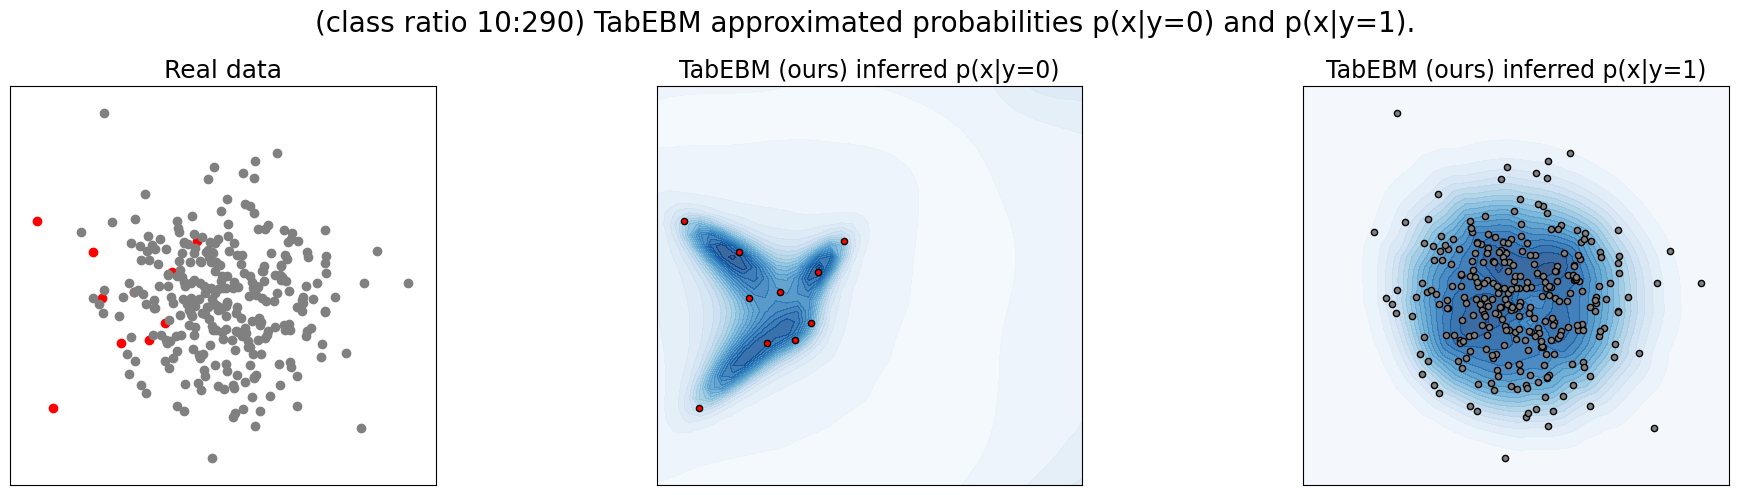

In [8]:
X, y = create_two_blobs_at_distance(num_samples=None, blob1_num_samples=150, blob2_num_samples=150, distance=2, random_state=40)
plot_tabebm_probabilities(X, y, title_prefix='(class ratio 150:150)', h=h)
plt.show()

X, y = create_two_blobs_at_distance(num_samples=None, blob1_num_samples=50, blob2_num_samples=250, distance=2, random_state=40)
plot_tabebm_probabilities(X, y, title_prefix='(class ratio 50:250)', h=h)
plt.show()

X, y = create_two_blobs_at_distance(num_samples=None, blob1_num_samples=25, blob2_num_samples=275, distance=2, random_state=40)
plot_tabebm_probabilities(X, y, title_prefix='(class ratio 25:275)', h=h)
plt.show()

X, y = create_two_blobs_at_distance(num_samples=None, blob1_num_samples=10, blob2_num_samples=290, distance=2, random_state=40)
plot_tabebm_probabilities(X, y, title_prefix='(class ratio 10:290)', h=h)
plt.show()

## === Finding: TabEBM is robust to class imbalance ===